# Capital One Data Science Challenge
Workday ID C973060  
JTN

### Imports

In [ ]:
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import sys
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, export_graphviz

## Question 1
Programatically download and load the trip data for September 2015.  
Report how many rows and columns of data you have loaded.

In [7]:
url = 'https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv'
filename = 'green_tripdata_2015-09.csv'
trips = pd.read_csv(filename)
n_rows, n_cols = trips.shape
print("Rows: {}, Cols: {}".format(n_rows, n_cols))

Rows: 1494926, Cols: 21


## Cleaning Data
Remove all trips with a negative or zero fare.  
Remove the Ehail fee since it's mostly missing.

In [9]:
trips = trips[trips['Fare_amount'] > 0]
if 'Ehail_fee' in trips:
    trips = trips.drop('Ehail_fee', axis='columns')
print(trips.shape)

(1488041, 20)


## Question 2
Plot a histogram of the number of trip distance.  
Report any structure you find and any hypotheses you have about that structure.

*The number of trips seems to decay exponentially with the trip distance, or follow a log-normal distribution. 
This is probably because people tend to travel short distances quite frequently,
and they're more likely to drive the farther away it is to save money.*

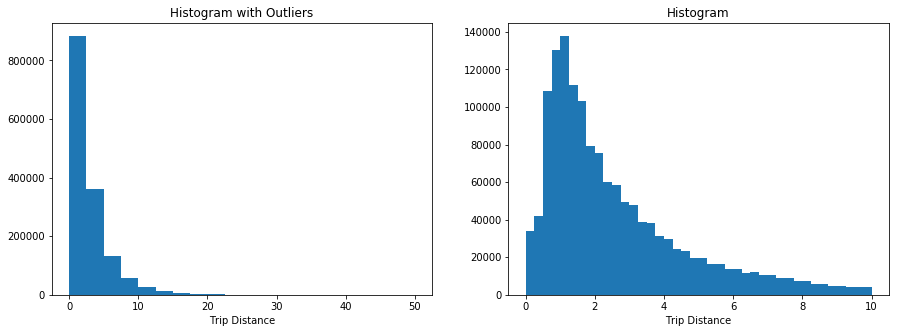

In [10]:
trip_distance = trips['Trip_distance']

fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].hist(trip_distance, bins=20, range=(0,50))
axs[0].set_xlabel("Trip Distance")
axs[0].set_title("Histogram with Outliers")
axs[1].hist(trip_distance, bins=40, range=(0,10))
axs[1].set_xlabel("Trip Distance")
axs[1].set_title("Histogram")
plt.show()

## Question 3
Report mean and median trip distance grouped by hour of day.  
We'd like to get a rough sense of identifying trips that originate or terminate at one of the NYC
airports. Provide a count of how many transactions fit this criteria, the average fare, and any
other interesting characteristics of these trips.

Using https://stackoverflow.com/questions/16266019/python-pandas-group-datetime-column-into-hour-and-minute-aggregations  
*The first approach I took was to define a circle of radius 0.01 (latitude/longitude units) around each airport, then filter by each trip's start and stop destination. Further improvement would be to map out the actual pickup areas around each airport and filter by that.*

Using http://www.nyc.gov/html/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf  
*The second approach I took was noticing that RateCodeID of `2` or `3` corresponds to JFK and Newark Airports. This seems more promising than drawing a manual radius.*

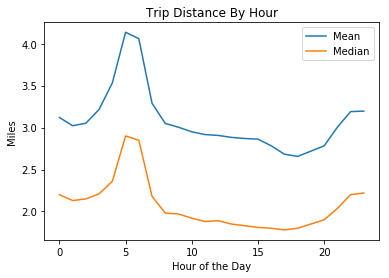

hour 0: mean 3.120, median 2.200
hour 1: mean 3.022, median 2.130
hour 2: mean 3.052, median 2.150
hour 3: mean 3.217, median 2.210
hour 4: mean 3.533, median 2.360
hour 5: mean 4.136, median 2.900
hour 6: mean 4.060, median 2.850
hour 7: mean 3.289, median 2.180
hour 8: mean 3.049, median 1.980
hour 9: mean 3.004, median 1.970
hour 10: mean 2.950, median 1.920
hour 11: mean 2.917, median 1.880
hour 12: mean 2.906, median 1.890
hour 13: mean 2.883, median 1.850
hour 14: mean 2.870, median 1.830
hour 15: mean 2.862, median 1.810
hour 16: mean 2.783, median 1.800
hour 17: mean 2.683, median 1.780
hour 18: mean 2.656, median 1.800
hour 19: mean 2.719, median 1.850
hour 20: mean 2.781, median 1.900
hour 21: mean 3.003, median 2.035
hour 22: mean 3.190, median 2.200
hour 23: mean 3.196, median 2.220


In [11]:
times = pd.DatetimeIndex(trips['lpep_pickup_datetime'])
hours = trips.groupby([times.hour])['Trip_distance']
    
t = hours.groups.keys()
plt.plot(t, hours.mean(), label="Mean")
plt.plot(t, hours.median(), label="Median")
plt.legend()
plt.title("Trip Distance By Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Miles")
plt.show()

for hour in hours:
    print("hour {}: mean {:.3f}, median {:.3f}".format(hour[0], hour[1].mean(), hour[1].median()))

In [12]:
# These three functions below are not used; they are kept around to show a history of work.
# (the code works, but using the RateCodeID works much better).
def airport_dist(trips, airport):
    """
    Returns:
        dist (float): the distance between each trip and the given airport.
    """
    pickup_dist = np.linalg.norm(trips[['Pickup_longitude', 'Pickup_latitude']] - airport, axis=1)
    dropoff_dist = np.linalg.norm(trips[['Dropoff_longitude', 'Dropoff_latitude']] - airport, axis=1)
    dist = np.minimum(pickup_dist, dropoff_dist)
    return dist

def min_airport_dist(trips, airports):
    """
    Returns:
        dist (float): the minimum distance between each trip and all airports.
    """
    return np.min([
            airport_dist(trips, airport) for airport in airports
        ], axis=0)

def trips_near_airports(trips, airports, epsilon=0.01):
    """
    Returns:
        trips_filtered (dataframe): the trips which are near an airport.
    """
    dist = min_airport_dist(trips, airports)
    trips_filtered = trips.iloc[dist < epsilon]
    return trips_filtered

### Here we have the functional code

def trips_near_airports_v2(trips):
    idx = (trips['RateCodeID'] == 2) | (trips['RateCodeID'] == 3)
    return trips[idx]

# List of (longitude, latitude) tuples
airports = np.array([
    [-73.7781, 40.6413], # JFK
    [-73.8740, 40.7769], # LaGuardia (LGA)
    [-74.1724, 40.7357] # Newark (EWR)
])
lga = airports[1]
display_epsilon = 0.5
filter_epsilon = 0.005
# Filter trips, keeping those near airports
# airport_trips = trips_near_airports(trips, airports, epsilon=filter_epsilon)
airport_trips = trips_near_airports_v2(trips)

# Plot everything
plt.scatter(airport_trips['Pickup_longitude'], airport_trips['Pickup_latitude'], color='blue', label="Pickups")
plt.scatter(airport_trips['Dropoff_longitude'], airport_trips['Dropoff_latitude'], color='green', label="Dropoffs")
plt.scatter(airports[:,0], airports[:,1], color='r', zorder=3, label="Airports")
plt.xlim([lga[0]-display_epsilon, lga[0]+display_epsilon])
plt.ylim([lga[1]-display_epsilon, lga[1]+display_epsilon])
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.title("Taxi Trips Near Airports")
plt.show()

# Print results
# print("There are {} trips with a pickup/dropoff within a {} latitude/longitude radius of an airport.".format(
#         airport_trips.shape[0], filter_epsilon))
print("There are {} trips with a pickup/dropoff at JFK or Newark.".format(airport_trips.shape[0]))
print("The average fare of these trips is ${:.2f}.".format(airport_trips['Fare_amount'].mean()))

There are 5390 trips with a pickup/dropoff at JFK or Newark.
The average fare of these trips is $51.68.


## Question 4
Build a derived variable for tip as a percentage of the total fare.  
Build a predictive model for tip as a percentage of the total fare. Provide an estimate of
performance using an appropriate sample, and show your work.


In [114]:
# Build a derived variable for tip pecentage
if 'Tip_pct' not in trips:
    trips['Tip_pct'] = trips['Tip_amount'] / trips['Fare_amount']

# Derived predictive model will use `Trip_distance`, `Ehail_fee`, `Payment_type`, `Trip_type `
list(trips)
ID_col = ['VendorID']
target_col = ['Tip_pct']
cat_cols = ['Payment_type', 'Trip_type ']
num_cols = ['Trip_distance', 'Fare_amount']

# trips.isnull().any()

Here we see that `Payment_type` is a clear indicator of whether or not there was a tip.  
Let's filter out data by that.

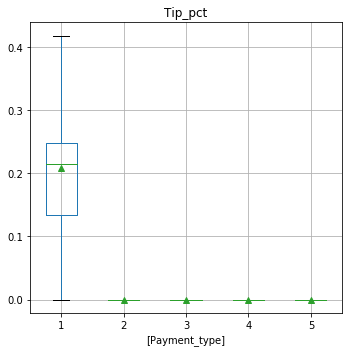

In [14]:
fig, ax = plt.subplots(1, figsize=(5,5))
trips.boxplot(['Tip_pct'], by=['Payment_type'], ax=ax, showfliers=False, showmeans=True)

plt.tight_layout()
plt.suptitle("")
plt.show()

Filter out by credit cards payment type.

In [15]:
trips_cc = trips[trips['Payment_type'] == 1]
trips_cc['Tip_pct'].describe()

count    700797.000000
mean          0.208912
std           0.581327
min           0.000000
25%           0.133333
50%           0.215238
75%           0.247273
max         150.000000
Name: Tip_pct, dtype: float64

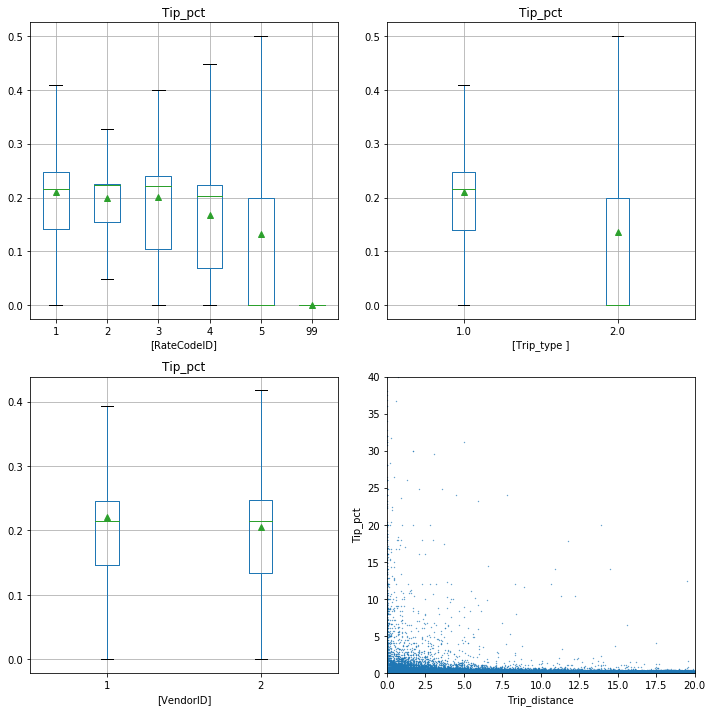

In [16]:
fig, axs = plt.subplots(2,2, figsize=(10,10))
axs = axs.flatten()
trips_cc.boxplot(['Tip_pct'], by=['RateCodeID'], ax=axs[0], showfliers=False, showmeans=True)
trips_cc.boxplot(['Tip_pct'], by=['Trip_type '], ax=axs[1], showfliers=False, showmeans=True)
trips_cc.boxplot(['Tip_pct'], by=['VendorID'], ax=axs[2], showfliers=False, showmeans=True)
trips_cc.plot.scatter('Trip_distance', 'Tip_pct', ax=axs[3], xlim=[0,20], ylim=[0,40], s=0.1)

plt.tight_layout()
plt.suptitle("")
plt.show()

## Feature Engineering
Add a `Trip_time` category. Does a shorter trip mean a happier customer who tips generously?

In [17]:
trips['Hour'] = pd.to_datetime(trips['lpep_pickup_datetime']).dt.hour
time_diff = (pd.to_datetime(trips['Lpep_dropoff_datetime']) - pd.to_datetime(trips['lpep_pickup_datetime']))
trips['Trip_time'] = time_diff / pd.Timedelta(minutes=1)
plt.scatter(trips['Trip_time'], trips['Tip_pct'])
plt.show()

In [18]:
stats.linregress(trips['Trip_time'], trips['Tip_pct'])

LinregressResult(slope=-2.9519703361807314e-05, intercept=0.09902726451573797, rvalue=-0.006893573401672989, pvalue=4.126827109604068e-17, stderr=3.5103474820793375e-06)

There appears to be no linear relationship between trip length and tip percentage.  
What about between average speed and tip percentage?

In [19]:
trips_nonzero = trips[trips['Trip_time'] != 0]
avg_speed = trips_nonzero['Trip_distance'] / trips_nonzero['Trip_time']
plt.scatter(avg_speed, trips_nonzero['Tip_pct'])
plt.xlim([0,500])
plt.ylim([0,50])
plt.show()

In [20]:
stats.linregress(avg_speed, trips_nonzero['Tip_pct'])

LinregressResult(slope=0.003498947561247118, intercept=0.09756373560091582, rvalue=0.030259964586644775, pvalue=3.3426665183047205e-298, stderr=9.477817230260746e-05)

There appears to be no linear relationship here either.

## Building a Predictive Model
Since most of the predictive power seems to come from categorical variables, we will use a decision tree.  

score: 0.18251878386466636


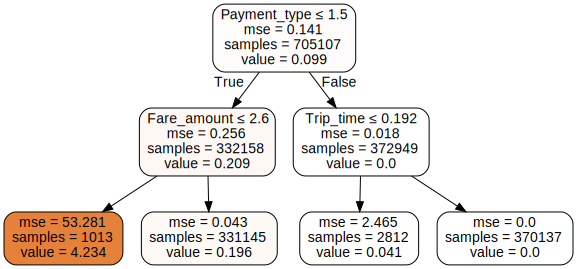

In [111]:
feature_cols = [
    'Payment_type',
    'RateCodeID',
    'Hour',
    'Pickup_longitude',
    'Pickup_latitude',
    'Dropoff_longitude',
    'Dropoff_latitude',
    'Passenger_count',
    'Trip_distance',
    'Fare_amount',
#     'Trip_type ',
    'Trip_time'
]
X_train, X_test, y_train, y_test = train_test_split(
    trips[feature_cols], trips['Tip_pct'])

reg = RandomForestRegressor(n_estimators=10, max_depth=2)
reg.fit(X_train, y_train)
print("score: {}".format(reg.score(X_test, y_test)))

# Visualize
sample_tree = reg.estimators_[0]
dot_data = export_graphviz(sample_tree, out_file=None, 
                         feature_names=feature_cols,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

So the predictive variables appear to be `Payment_type`, `Fare_amount`, and `Hour`.  
Let's prune our decision tree regressor to only use these variables, then go deeper with another ensemble.

score: 0.22606296442184415


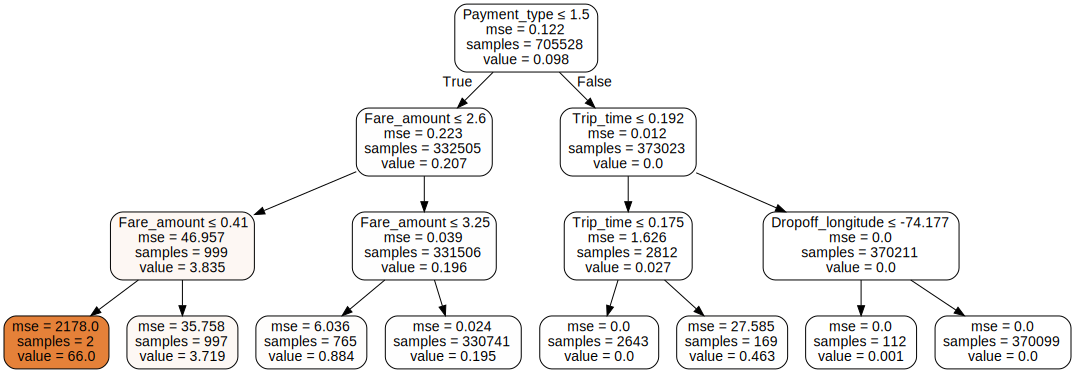

In [113]:
feature_cols2 = [
    'Payment_type',
    'RateCodeID',
    'Fare_amount',
    'Hour'
]

reg2 = RandomForestRegressor(n_estimators=10, max_depth=3)
reg2.fit(X_train, y_train)
print("score: {}".format(reg2.score(X_test, y_test)))

sample_tree2 = reg2.estimators_[0]
dot_data = export_graphviz(sample_tree2, out_file=None, 
                         feature_names=feature_cols,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

### Analyzing the Predictive Model
First, we see that splitting on payment type is extremely predictive and reflected in every decision tree, as the initial
data analysis showed.  
Fare amount and trip time are also important splitting variables. This is because short trip times have a small fare amount,
so even if people tip a constant amount (say `$1`), that can be a large tip percentage.  Our MSE is greatest on the left two 
nodes. The leftmost node (MSE 2178) has two outliers, so let's focus on the node to the right (MSE 35.758).  
We have ~1000 samples with an average tip percentage of 300%! These correspond to a small fare, between `$0.41`and `$2.60`.  
Predicting these can be difficult, so this is acceptable variance for our predictive model, as long as we're aware of the 
lack of predictive power among these.  

Our final result is an $R^2$ value of $0.226$. This accounts for a fifth of the variance in the model, meaning there is still room for improvement as long as random error is lower than 80%.

## Question 5 - Option A
Build a derived variable representing the average speed over the course of a trip.  
Can you perform a test to determine if the average trip speeds are materially the same in all weeks of September? If you decide they are not the same, can you form a hypothesis regarding why they differ?  
Can you build up a hypothesis of average trip speed as a function of time of day?

In [145]:
# We'll build a derived variable using miles per hour
time_diff = (pd.to_datetime(trips['Lpep_dropoff_datetime']) - pd.to_datetime(trips['lpep_pickup_datetime']))
hours_diff = time_diff / pd.Timedelta(hours=1)
trips['Trip_speed'] = trips['Trip_distance'] / hours_diff
trips['Trip_speed'] = trips['Trip_distance'].replace([np.inf], np.nan)

trips_true = trips[trips['Trip_speed'] < 200].dropna()
trips_true['Trip_speed'].describe()

count    1.488035e+06
mean     2.971446e+00
std      3.027338e+00
min      0.000000e+00
25%      1.100000e+00
50%      1.980000e+00
75%      3.740000e+00
max      1.347000e+02
Name: Trip_speed, dtype: float64

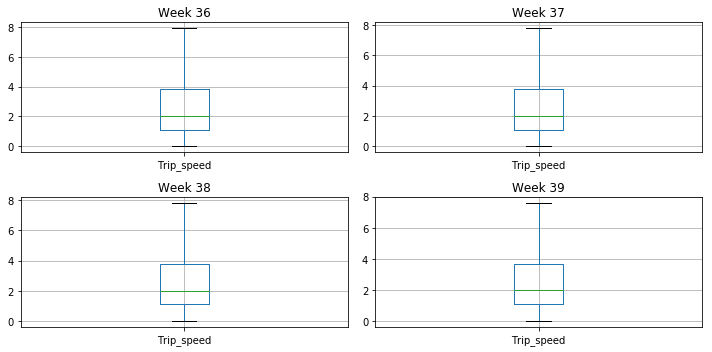

In [185]:
# Group the true trips by week
times = pd.DatetimeIndex(trips['lpep_pickup_datetime'])
weeks = trips.groupby([times.week])

fig, axs = plt.subplots(2, 2, figsize=(10,5))
axs = axs.flatten()
for ax, week in zip(axs, weeks):
    week_num, week_trips = week
    week_trips.boxplot('Trip_speed', showfliers=False, ax=ax)
    ax.set_title("Week {}".format(week_num))
plt.tight_layout()
plt.show()

# week_trips
weeks['Trip_speed'].mean() 
t = list(weeks.groups.keys())
plt.plot(t, weeks['Trip_speed'].mean(), label="Average Trip Speed")
plt.xlabel("Week No.")
plt.xticks(list(t))
plt.ylabel("Average Trip Speed (mph)")
plt.title("Average Trip Speed Per Week")
plt.show()


The distributions look extremely similar in the boxplots, yet there seems to be a clear downward trend in the line chart.  
Let's turn to statistics! Since we're looking at average speed, which is the sum of many random variables, we assume that average speed is normally distributed with mean $\mu$ and variance $\frac{\sigma^2}{n}$, then look at p-values by calculating standard deviations from the mean.  
Let's compare the weeks 36 and 40, since they're furthest apart.

In [203]:
week_36 = weeks.get_group(36)['Trip_speed']
week_40 = weeks.get_group(40)['Trip_speed']

mu_36 = week_36.mean()
mu_40 = week_40.mean()

var_36 = ((week_36 - mu_36)**2).mean() / len(week_36)
var_40 = ((week_40 - mu_40)**2).mean() / len(week_40)

std_36 = np.sqrt(var_36)
std_40 = np.sqrt(var_40)

print("μ_36: {:.3f}, σ_36: {:.5f}".format(mu_36, std_36))
print("μ_40: {:.3f}, σ_40: {:.5f}".format(mu_40, std_40))

print("So a 95% confidence interval for μ_36 is ({:.3f}, {:.3f})".format(mu_36-2*std_36, mu_36+2*std_36))
print("So a 95% confidence interval for μ_40 is ({:.3f}, {:.3f})".format(mu_40-2*std_40, mu_40+2*std_40))

μ_36: 3.032, σ_36: 0.00565
μ_40: 2.814, σ_40: 0.00829
So a 95% confidence interval for μ_36 is (3.021, 3.044)
So a 95% confidence interval for μ_40 is (2.797, 2.830)


These confidence intervals do not overlap, so we can be confident that there is a statistically
significant difference.  
One possible explanation is that as summer turns to winter, the roads become more wet, icy, or snowy, leading to cab drivers driving more cautiously. There could be more drivers as opposed to bikers/walkers, meaning more congestion in the inner city.

In [206]:
times = pd.DatetimeIndex(trips['lpep_pickup_datetime'])
hours = trips.groupby([times.hour])['Trip_speed']
    
t = hours.groups.keys()
plt.plot(t, hours.mean(), label="Mean")
plt.plot(t, hours.median(), label="Median")
plt.legend()
plt.title("Average Speed By Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Miles Per Hour")
plt.show()

This is nearly an exact copy of the `Trip_distance by Hour` graph. The longer the trip is, the
more likely you are to drive on highways with faster speed.  
Additionally, people are in a hurry to get to work, and it peaks early (5am) because the roads
are less congested, but people are still traveling long distances.